In [1]:
import sys
sys.path.append("..//")
from utils import *

sns.set_style("white")

Using TensorFlow backend.


GPU availbility: ['/job:localhost/replica:0/task:0/device:GPU:0']


In [88]:
def convert_coords(x_coord, y_coord, height, width):
    return int(x_coord * width), int(y_coord * height)
def padding(num):
    zeros = (4-len(str(num)))*"0"
    return zeros+str(num)
def time_to_millisec(minute, second):
    return (minute*60 + second) * 1000
def dist_color(true_x, true_y, pred_x, pred_y, height, width, scale = 255, factor = 3.5):
    max_diff = (height**2 + width**2)**0.5
    return min((((true_x-pred_x)**2 + (true_y-pred_y)**2)**0.5)/max_diff * scale * factor, 255)
#     return ((true_x-pred_x)**2 + (true_y-pred_y)**2)**0.5

In [3]:
# P_id and task selected to export
p_id = 'P_10'
task = '1491597580453_15_-study-educational_advantages_of_social_networking_sites_writing.webm_frames'
should_contain = 'educational_advantages_of_social_networking_sites'
start_time = time_to_millisec(13, 15.6) # hard-coded start time for the task
video_path = "D://WebGazerETRA2018Dataset_Release20180420//"+p_id+"//"+p_id+".flv"
file_save = EXPORT_PATH + '09-map-prediction-back-to-video//'
frame_img_save = file_save + p_id +'_frame_imgs//'

# Get 3 coordinates ready - webgazer, cnn preds, and truth

In [4]:
# Load in validation set and model
suffix = '_pc'
BATCH_SIZE = 32
INIT_LR = 5e-5
DROPOUT = 30
X_val = pickle_loader(['X_val'+suffix])
coords = pd.read_csv(MST_PATH + 'df_val'+suffix+'.csv')

# Load the best model and predict
suffix += "_clip"
model_name = "resnet50_mae_adam_"+str(BATCH_SIZE)+"_"+str(INIT_LR)+"_"+str(DROPOUT)+suffix
base_filepath = MODEL_SAVE_PATH + model_name + ".hdf5"
print("Loading model:", model_name)
model = load_model(base_filepath)
val_pred_xy = model.predict(X_val, batch_size=BATCH_SIZE, verbose=1)

# Add prediction to df
coords['cnn_pred_x'] = val_pred_xy[0]
coords['cnn_pred_y'] = val_pred_xy[1]
coords['cnn_pred_x'] = np.clip(coords['cnn_pred_x'], 0, 1)
coords['cnn_pred_y'] = np.clip(coords['cnn_pred_y'], 0, 1)

Loading: X_val_pc
Loading model: resnet50_mae_adam_32_5e-05_30_pc_clip
47110/47110 [==============================] - 40s 857us/step


In [5]:
coords = coords[coords['task'].str.contains(should_contain)]
coords = coords[coords['participant'] == p_id]
coords.shape

(4440, 12)

In [6]:
df = pd.read_csv(MST_PATH + 'all_img_facial_lankmarks.csv')[['frameImageFile', 'id']]
df = pd.merge(df, coords, on = 'id', how = 'right')
df.shape

(4440, 13)

# Get frame images from screen recording

In [7]:
# Load in all imgs and restrict to the pid and task
all_img = pd.read_csv(MST_PATH + 'all_img.csv')
all_img = all_img[all_img['participant'] == p_id]
all_img = all_img[all_img['task'] == task].reset_index(drop = True)
task_start_time = np.min(all_img['frameTimeEpoch']) # Get start time 

# Create the id column
all_img['img_name'] = all_img['frameImageFile'].str.split("\\").apply(lambda x:x[-1][:-4])
all_img['id'] = [p + "_||_" + task + "_||_" + img_name for p,task,img_name in zip(all_img['participant'], all_img['task'], all_img['img_name'])]
print(all_img.shape)
all_img.head(1)

(4787, 13)


,participant,frameImageFile,frameTimeEpoch,frameNum,webGazerX,webGazerY,tobiiLeftScreenGazeX,tobiiLeftScreenGazeY,tobiiRightScreenGazeX,tobiiRightScreenGazeY,task,img_name,id
0,P_10,D:\FramesDataset\P_10\1491597580453_15_-study-...,1491598586172,0,0.234896,0.354167,0.433696,0.407383,0.436691,0.362934,1491597580453_15_-study-educational_advantages...,frame_00000000_00000000,P_10_||_1491597580453_15_-study-educational_ad...


In [8]:
# Now map the frame image of participant to frame image of the screen
to_drop = np.intersect1d(list(all_img), list(df)).tolist()
to_drop.remove('id')
all_img = pd.merge(all_img.drop(to_drop, 1), df, on = 'id', how = 'inner')
all_img.shape

(4440, 20)

In [9]:
all_img.head(5)

,frameTimeEpoch,frameNum,tobiiLeftScreenGazeX,tobiiLeftScreenGazeY,tobiiRightScreenGazeX,tobiiRightScreenGazeY,img_name,id,frameImageFile,coord_x,coord_y,path,sharpness,participant,task,webGazerX,webGazerY,setting,cnn_pred_x,cnn_pred_y
0,1491598588452,61,-1.0,-1.0,0.334895,1.721810,frame_00000061_00002280,P_10_||_1491597580453_15_-study-educational_ad...,D:\FramesDataset\P_10\1491597580453_15_-study-...,0.334895,1.721810,D:\david_thesis\0_data_lan\datasets\mst\stitch...,0.79200,P_10,study-educational_advantages_of_social_network...,0.338021,0.255833,PC,0.316552,0.449605
1,1491598588632,66,-1.0,-1.0,0.335900,1.724883,frame_00000066_00002460,P_10_||_1491597580453_15_-study-educational_ad...,D:\FramesDataset\P_10\1491597580453_15_-study-...,0.335900,1.724883,D:\david_thesis\0_data_lan\datasets\mst\stitch...,0.80275,P_10,study-educational_advantages_of_social_network...,-0.171354,0.329167,PC,0.439986,0.360754
2,1491598588632,67,-1.0,-1.0,0.335900,1.724883,frame_00000067_00002460,P_10_||_1491597580453_15_-study-educational_ad...,D:\FramesDataset\P_10\1491597580453_15_-study-...,0.335900,1.724883,D:\david_thesis\0_data_lan\datasets\mst\stitch...,0.80350,P_10,study-educational_advantages_of_social_network...,-0.215625,0.367500,PC,0.486922,0.362706
3,1491598588752,69,-1.0,-1.0,0.324346,1.686958,frame_00000069_00002580,P_10_||_1491597580453_15_-study-educational_ad...,D:\FramesDataset\P_10\1491597580453_15_-study-...,0.324346,1.686958,D:\david_thesis\0_data_lan\datasets\mst\stitch...,0.78950,P_10,study-educational_advantages_of_social_network...,-0.016667,0.377500,PC,0.421883,0.442529
4,1491598588752,70,-1.0,-1.0,0.324346,1.686958,frame_00000070_00002580,P_10_||_1491597580453_15_-study-educational_ad...,D:\FramesDataset\P_10\1491597580453_15_-study-...,0.324346,1.686958,D:\david_thesis\0_data_lan\datasets\mst\stitch...,0.77625,P_10,study-educational_advantages_of_social_network...,-0.133333,0.372500,PC,0.348088,0.455676


In [92]:
ofs = 10
font = cv2.FONT_HERSHEY_SIMPLEX

for i in all_img.index[:500]:
    sec = all_img.loc[i, 'frameTimeEpoch'] - task_start_time + start_time
    vidcap = cv2.VideoCapture(video_path)
    vidcap.set(cv2.CAP_PROP_POS_MSEC, sec)      # just cue to 20 sec. position
    success,img = vidcap.read()
    height, width, channels = img.shape
    subject_img = cv2.imread(all_img.loc[i,'frameImageFile'])
    s_h, s_w, s_c = subject_img.shape
    print(i, "success", success)
    if success:
        true_x, true_y = convert_coords(all_img.loc[i,'coord_x'], all_img.loc[i,'coord_y'], height, width)
        cnn_x, cnn_y = convert_coords(all_img.loc[i,'cnn_pred_x'], all_img.loc[i,'cnn_pred_y'], height, width)
        wg_x, wg_y = convert_coords(all_img.loc[i,'webGazerX'], all_img.loc[i,'webGazerY'], height, width)
        cnn_c = dist_color(true_x, true_y, cnn_x,cnn_y,height, width)
        wg_c = dist_color(true_x, true_y, wg_x,wg_y,height, width)
        cv2.circle(img,(true_x,true_y), 10, (0,0,255), -1)
        cv2.circle(img,(cnn_x,cnn_y), 10, (cnn_c,255,cnn_c), -1)
        cv2.circle(img,(wg_x,wg_y), 10, (255,wg_c,wg_c), -1)   
        cv2.putText(img,'Truth',(true_x+ofs,true_y+ofs), font, 1,(0,0,255),2,cv2.LINE_AA)
        cv2.putText(img,'CNN',(cnn_x+ofs,cnn_y+ofs), font, 1,(cnn_c,255,cnn_c),2,cv2.LINE_AA)
        cv2.putText(img,'WebGazer',(wg_x+ofs,wg_y+ofs), font, 1,(255,wg_c,wg_c),2,cv2.LINE_AA)
        img[height-s_h:height, width-s_w:width] = subject_img
        cv2.imwrite(frame_img_save + p_id +"_frame_" + padding(i) + ".jpg", img)

0 success True
1 success True
2 success True
3 success True
4 success True
5 success True
6 success True
7 success True
8 success True
9 success True
10 success True
11 success True
12 success True
13 success True
14 success True
15 success True
16 success True
17 success True
18 success True
19 success True
20 success True
21 success True
22 success True
23 success True
24 success True
25 success True
26 success True
27 success True
28 success True
29 success True
30 success True
31 success True
32 success True
33 success True
34 success True
35 success True
36 success True
37 success True
38 success True
39 success True
40 success True
41 success True
42 success True
43 success True
44 success True
45 success True
46 success True
47 success True
48 success True
49 success True
50 success True
51 success True
52 success True
53 success True
54 success True
55 success True
56 success True
57 success True
58 success True
59 success True
60 success True
61 success True
62 success True
63

488 success True
489 success True
490 success True
491 success True
492 success True
493 success True
494 success True
495 success True
496 success True
497 success True
498 success True
499 success True


In [83]:
# Generate the movie
from moviepy.editor import *
fps = 3
clip = ImageSequenceClip(frame_img_save, fps=fps)
clip.write_videofile(file_save+p_id+"_output_fps_"+str(fps)+".mp4")

Moviepy - Building video D:\david_xu_thesis\0_data_lan\export\09-map-prediction-back-to-video//P_10_output_fps_3.mp4.
Moviepy - Writing video D:\david_xu_thesis\0_data_lan\export\09-map-prediction-back-to-video//P_10_output_fps_3.mp4



Moviepy - Done !
Moviepy - video ready D:\david_xu_thesis\0_data_lan\export\09-map-prediction-back-to-video//P_10_output_fps_3.mp4


In [93]:
# Generate the movie
from moviepy.editor import *
fps = 10
clip = ImageSequenceClip(frame_img_save, fps=fps)
clip.write_videofile(file_save+p_id+"_output_fps_"+str(fps)+".mp4")

Moviepy - Building video D:\david_xu_thesis\0_data_lan\export\09-map-prediction-back-to-video//P_10_output_fps_10.mp4.
Moviepy - Writing video D:\david_xu_thesis\0_data_lan\export\09-map-prediction-back-to-video//P_10_output_fps_10.mp4



Moviepy - Done !
Moviepy - video ready D:\david_xu_thesis\0_data_lan\export\09-map-prediction-back-to-video//P_10_output_fps_10.mp4


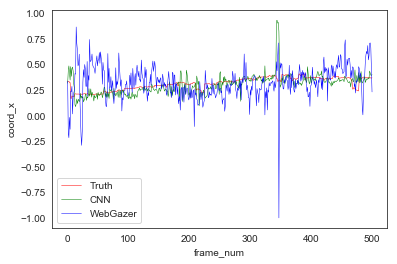

In [76]:
temp = all_img.loc[:500, ]
plt.plot(temp.index, temp['coord_x'], label = "Truth", c = 'r', lw = 0.5)
plt.plot(temp.index, temp['cnn_pred_x'], label = "CNN", c = 'g', lw = 0.5)
plt.plot(temp.index, temp['webGazerX'], label = "WebGazer", c = 'b', lw = 0.5)
plt.legend()
plt.xlabel('frame_num')
plt.ylabel('coord_x')
plt.savefig(file_save+p_id+"_x_frame", fmt = 'jpg', dpi = 300)
plt.show()

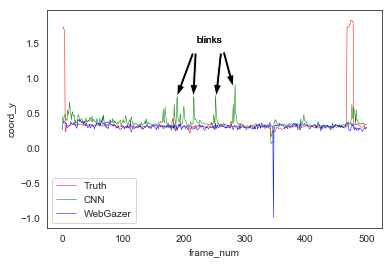

In [77]:
temp = all_img.loc[:500, ]
plt.plot(temp.index, temp['coord_y'], label = "Truth", c = 'r', lw = 0.5)
plt.plot(temp.index, temp['cnn_pred_y'], label = "CNN", c = 'g', lw = 0.5)
plt.plot(temp.index, temp['webGazerY'], label = "WebGazer", c = 'b', lw = 0.5)
plt.legend()
plt.xlabel('frame_num')
plt.ylabel('coord_y')
plt.annotate('blinks', xy=(185, 0.65), xytext=(220, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.1, width=3, headwidth = 8))
plt.annotate('blinks', xy=(215, 0.65), xytext=(220, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.1, width=3, headwidth = 8))
plt.annotate('blinks', xy=(252, 0.65), xytext=(220, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.1, width=3, headwidth = 8))
plt.annotate('blinks', xy=(283, 0.8), xytext=(220, 1.5),
            arrowprops=dict(facecolor='black', shrink=0.1, width=3, headwidth = 8))
plt.savefig(file_save+p_id+"_y_frame", fmt = 'jpg', dpi = 300)
plt.show()

In [12]:
# import matplotlib.image as mpimg
# for i in all_img.index:
#     sec = all_img.loc[i, 'frameTimeEpoch'] - start_time
#     vidcap = cv2.VideoCapture(video_path)
#     vidcap.set(cv2.CAP_PROP_POS_MSEC, sec)      # just cue to 20 sec. position
#     success,img = vidcap.read()
#     height, width, channels = img.shape
#     print("success", success)
#     if success:
#         cv2.imwrite(frame_img_save + "frame_" + str(sec) + ".jpg", img)
#         img = mpimg.imread(frame_img_save + "frame_" + str(sec) + ".jpg")
#         true_x, true_y = convert_coords(all_img.loc[i,'coord_x'], all_img.loc[i,'coord_y'], height, width)
#         cnn_x, cnn_y = convert_coords(all_img.loc[i,'cnn_pred_x'], all_img.loc[i,'cnn_pred_y'], height, width)
#         wg_x, wg_y = convert_coords(all_img.loc[i,'webGazerX'], all_img.loc[i,'webGazerY'], height, width)
#         plt.scatter([true_x], [true_y],  c = 'r', label = "Actual")
#         plt.scatter([cnn_x], [cnn_y], c = 'gold', label = "CNN")
#         plt.scatter([wg_x], [wg_y], c = 'blue', label = "WebGazer")
#         plt.legend()
#         plt.savefig(frame_img_save + "frame" + str(sec) + ".jpg", fmt = 'jpg', dpi = 300)